# First Keras Notebook

An attempt to recreate the network in tests.ipynb except sorting by tag so we have 3 less possible outputs, and including a no-tag option

In [1]:
import uproot as ur
import uproot_methods as urm
import numpy as np
import awkward
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical   
from sklearn.metrics import roc_curve

import tools

filename = 'user.jagrundy.20736236._000001.MiniNTuple.root'

Using TensorFlow backend.


Load ntuple, get the data we need from the file

In [2]:
s_table = tools.open_file(filename, sort_by="tag")

sorting data by tag


Filters

In [3]:
# filter by realistic situation where we have 3 tags and 3 or 4 jets.
# ignore the case where there may be >4 since those are pretty rare
nb4 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets exist
nt3 = s_table.nbtags==3  # 3 b tags
nb4nt3 = nb4 & nt3
events = s_table[nb4nt3]
n_events = len(events)
print(n_events)

308955


Get some quantities we'll use a lot

In [4]:
pt = events["resolved_lv"].pt
eta = events["resolved_lv"].eta
phi = events["resolved_lv"].phi
tag = events["tag"] # tag[index] = [1, 1, 1, 0, 0, ...] (len >= 4)
truth = events["truth"]

Then prepare for keras stuff

In [5]:
# filler value for padded pt, eta, phi
fill = -10
cutoff = 10

# cut off and pad
# cutoff+1 so we can have a no-4th-jet option as last index
padded_true = pad_sequences(truth,padding='post')[:,:cutoff+1]
padded_tag = pad_sequences(tag, padding='post')[:,:cutoff+1]
padded_pt = pad_sequences(pt, padding='post', dtype='float32', value = fill)[:,:cutoff+1]
padded_eta = pad_sequences(eta, padding='post', dtype='float32', value = fill)[:,:cutoff+1]
padded_phi = pad_sequences(phi, padding='post', dtype='float32', value = fill)[:,:cutoff+1]

In [6]:
# 1 = should have been tagged but wasn't. 0 = correctly tagged (or not tagged)
untagged = np.logical_xor(padded_true, padded_tag).astype(int)

# n_untagged[i] = number of untagged real jets in i-th event
n_untagged = np.count_nonzero(untagged, axis=1)

# consider the following:
"""
    We sorted events by tag, so we could have something like:
    truth:      [0 1 0 1 1 1 0 0 0 0 0]
    tag:        [1 1 1 0 0 0 0 0 0 0 0]
    n_untagged: 5

    even though there are only 4 real events, and 3 jets have been tagged.

    We want to consider only the cases where the 3 jets are correctly tagged,
    so we have take n_untagged == 1
"""

# cases where there is no true 4th jet
where_no_4th = (n_untagged == 0)

# say that there's a jet in the last index with these parameters
untagged[where_no_4th, -1] = 1
padded_pt[where_no_4th, -1] = -100
padded_eta[where_no_4th, -1] = -100
padded_phi[where_no_4th, -1] = -100

# for now, consider only the events where one jet is not tagged
# or where there are only 3 real b jets
untagged = untagged[n_untagged <= 1]
pt = padded_pt[n_untagged <= 1]
eta = padded_eta[n_untagged <= 1]
phi = padded_phi[n_untagged <= 1]

# snip off the 3 first jets since they're already tagged correctly
# (given our filtering procedure above)
untagged = untagged[:, 3:]
pt = pt[:, 3:]
eta = eta[:, 3:]
phi = phi[:, 3:]

# where does the untagged jet occur?
missed_jet_index = np.where(untagged == 1)[1]

# so this should be the output of our model
# 7 = no 4th jet, the rest means set that index's jet = 4th
print(missed_jet_index)

[7 7 7 ... 4 3 2]


In [7]:
# scale data to be keras-friendly
scaler_pt = StandardScaler()
scaler_eta = StandardScaler()
scaler_phi = StandardScaler()

# s for scaled
s_pt = scaler_pt.fit_transform(pt)
s_eta = scaler_eta.fit_transform(eta)
s_phi = scaler_phi.fit_transform(phi)

# stack pt, eta, phi for input into model
s_in = np.column_stack((s_pt, s_eta, s_phi))

Split data into training, validation, and testing subsets

In [8]:
# split missed_jet into training, validation, testing subsets
train, val, test = tools.splitTVT(untagged, trainfrac=0.7, testfrac=0.2)

To do: experiment with different kinds of networks

In [9]:
model = Sequential()
model.add(Dense(24, input_dim=24, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(24, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(8, kernel_initializer='normal', activation='softmax'))
        # compile model
optimizer = Adam(lr=5e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [10]:
history = model.fit(s_in[train], untagged[train], validation_data=(s_in[val], untagged[val]), epochs = 200, batch_size = 200, verbose = 1)

- val_acc: 0.7964
Epoch 59/200
212748/212748 [==============================] - 2s 7us/step - loss: 0.4504 - acc: 0.7960 - val_loss: 0.4511 - val_acc: 0.7957
Epoch 60/200
212748/212748 [==============================] - 2s 7us/step - loss: 0.4503 - acc: 0.7957 - val_loss: 0.4508 - val_acc: 0.7963
Epoch 61/200
212748/212748 [==============================] - 2s 7us/step - loss: 0.4503 - acc: 0.7960 - val_loss: 0.4506 - val_acc: 0.7961
Epoch 62/200
212748/212748 [==============================] - 2s 7us/step - loss: 0.4501 - acc: 0.7960 - val_loss: 0.4505 - val_acc: 0.7961
Epoch 63/200
212748/212748 [==============================] - 2s 7us/step - loss: 0.4500 - acc: 0.7958 - val_loss: 0.4503 - val_acc: 0.7963
Epoch 64/200
212748/212748 [==============================] - 2s 7us/step - loss: 0.4499 - acc: 0.7961 - val_loss: 0.4502 - val_acc: 0.7964
Epoch 65/200
212748/212748 [==============================] - 2s 7us/step - loss: 0.4498 - acc: 0.7958 - val_loss: 0.4501 - val_acc: 0.7960
Ep

<Figure size 432x288 with 0 Axes>

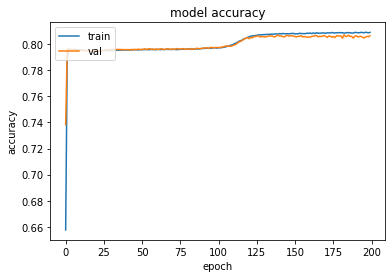

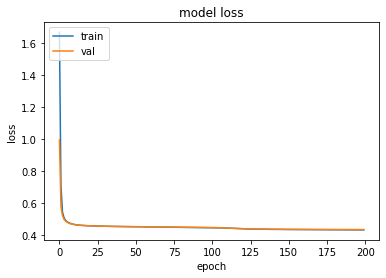

In [11]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('Plots/accuracy_{}.pdf'.format(layer_name))
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('Plots/loss_{}.pdf'.format(layer_name))
plt.show()

Seems to be working!

In [12]:
nn_score = model.predict(s_in)

In [13]:
test_nn_score = nn_score[test]

# sort nn_score highest to lowest
indices =test_nn_score.argsort()

# prepare for roc curve plot
best_index_asc = test_nn_score.argsort(axis=1)
best_index = best_index_asc[:,::-1]
test_mj = untagged[test]
s_test_mj = test_mj[np.arange(test_mj.shape[0])[:,None], best_index]
s_test_score = test_nn_score[np.arange(test_nn_score.shape[0])[:,None], best_index]
max_true = to_categorical(s_test_mj[:,0], num_classes = 2)
max_true = s_test_mj[:,0]
max_val = s_test_score[:,0]
fpr, tpr, thresholds = roc_curve(max_true, max_val, pos_label=1)

<Figure size 432x288 with 0 Axes>

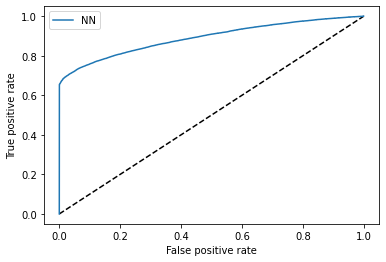

In [14]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='NN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
# plt.savefig('Plots/roc_combine2_cnn.pdf')
plt.show()